In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
    UpSampling2D, Dropout, Activation, Flatten, Reshape, merge, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import Initializer, RandomNormal
from keras.regularizers import l2
from keras.models import Model
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz
import random

Using TensorFlow backend.


In [4]:
'''Note that in the paper, the output of the generative model
is tanh activation layer, which will be the input to our
discriminative model. So we need to normalize input images 
to tanh scale (-1.0 to 1.0)'''

x_train = bcolz.open('data/x_train.bc')[:]
x_train = (x_train.astype(np.float32)/255.0) * 2.0 - 1.0

In [5]:
'''Discriminator network'''
discriminator_input = Input(x_train.shape[1:])
discriminator_x = Conv2D(256, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_input)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Conv2D(512, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)
discriminator_x = Flatten()(discriminator_x)

discriminator_x = Dense(256, kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Dense(1,activation='sigmoid')(discriminator_x)

discriminator_model = Model(discriminator_input,discriminator_x)
discriminator_model.compile(RMSprop(lr=0.00005),loss='mean_squared_error')

In [6]:
'''Generator network'''
generator_input = Input((100,))
generator_x = Dense(1024*7*7, kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_input)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = Reshape((7,7,1024))(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(512, (3,3), padding='same', 
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(256, (3,3), padding='same', 
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(128, (3,3), padding='same', 
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(64, (3,3), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(32, (3,3), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(3, (1,1), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = Activation('tanh')(generator_x)

generator_model = Model(generator_input,generator_x)
generator_model.compile(RMSprop(lr=0.00005),loss='mean_squared_error')

In [7]:
'''Freeze discriminator'''
discriminator_model.trainable = False
for layer in discriminator_model.layers:
    layer.trainable = False

'''GAN = generator + discriminator'''
gan_input = Input((100,))
gan_x = generator_model(gan_input)
gan_x = discriminator_model(gan_x)
model = Model(gan_input, gan_x)
model.compile(RMSprop(lr=0.00005), loss = "mean_squared_error")

In [8]:
'''Train discriminator for 1 epoch as a start'''
init_data = len(x_train)//2

real = np.random.permutation(x_train)[:init_data]
fake = generator_model.predict(np.random.rand(init_data,100))
x_init = np.concatenate((real,fake))

real_label = np.zeros((init_data,1))
fake_label = np.ones((init_data,1))
y_init = np.concatenate((real_label,fake_label))

In [9]:
'''Unfreeze discriminator'''
discriminator_model.trainable = True
for layer in discriminator_model.layers:
    layer.trainable = True

discriminator_model.fit(x_init,y_init,batch_size=64,epochs=1)
#Clamp the weights
for layer in discriminator_model.layers:
    weights = layer.get_weights()
    weights = [np.clip(w, -0.01, 0.01) for w in weights]
    layer.set_weights(weights)

Epoch 1/1
9998/9998 [==============================] - 42s - loss: 0.0633    


In [10]:
discriminator_loss = []
generator_loss = []
num_data = len(x_train)

In [11]:
'''Note that our discriminator and generator models are referenced
by our GAN and we do not want the discriminator part of the GAN to be
trained when trying to minimize generator losses. To do so, we can just
do it by freezing discriminator model before training the generator'''

model.optimizer = RMSprop(lr=0.00005)
discriminator_model.optimizer = RMSprop(lr=0.00005)
generator_model.optimizer = RMSprop(lr=0.00005)

num_iterations = 50000
real_per_iter = 32
fake_per_iter = 32

real_label = np.zeros((real_per_iter,1))
fake_label = np.ones((fake_per_iter,1))
y_mini = np.concatenate((real_label,fake_label))

repeat_discriminator = 100
repeat_generator = 1

for i in range(num_iterations):
    print('Iteration #%d' % i)
    if (len(discriminator_loss)>25):
        repeat_discriminator = 5
    
    '''Unfreeze discriminator'''
    discriminator_model.trainable = True
    for layer in discriminator_model.layers:
        layer.trainable = True
        
    '''Training discriminator'''
    for k in range(repeat_discriminator):
        '''Create real and fake data, as well as their labels'''
        real = x_train[np.random.randint(0,high=num_data,size=real_per_iter)]
        fake = generator_model.predict(np.random.rand(fake_per_iter,100))
        x_mini = np.concatenate((real, fake))
        discriminator_loss.append(discriminator_model.train_on_batch(x_mini,y_mini))
        #Clamp the weights
        for layer in discriminator_model.layers:
            weights = layer.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            layer.set_weights(weights)
    
    '''Freeze discriminator'''
    discriminator_model.trainable = False
    for layer in discriminator_model.layers:
        layer.trainable = False
    
    '''Training generator'''
    for k in range(repeat_generator):
        generator_x = np.random.rand(fake_per_iter*2,100)
        generator_y = np.zeros((fake_per_iter*2,1)) #we want it to be classified as real
        generator_loss.append(model.train_on_batch(generator_x, generator_y))
    
    '''Show losses'''
    print('Discriminator loss = %.6f Generator loss = %.6f'
          % (discriminator_loss[len(discriminator_loss)-1],
             generator_loss[len(generator_loss)-1]))

Iteration #0
Discriminator loss = 0.008133 Generator loss = 0.988362
Iteration #1
Discriminator loss = 0.007871 Generator loss = 0.971426
Iteration #2
Discriminator loss = 0.007657 Generator loss = 0.940050
Iteration #3
Discriminator loss = 0.007156 Generator loss = 0.886809
Iteration #4
Discriminator loss = 0.006833 Generator loss = 0.860078
Iteration #5
Discriminator loss = 0.006443 Generator loss = 0.874704
Iteration #6
Discriminator loss = 0.006062 Generator loss = 0.892904
Iteration #7
Discriminator loss = 0.005693 Generator loss = 0.890805
Iteration #8
Discriminator loss = 0.006537 Generator loss = 0.657791
Iteration #9
Discriminator loss = 0.005348 Generator loss = 0.795344
Iteration #10
Discriminator loss = 0.004945 Generator loss = 0.830628
Iteration #11
Discriminator loss = 0.005547 Generator loss = 0.606794
Iteration #12
Discriminator loss = 0.004519 Generator loss = 0.695135
Iteration #13
Discriminator loss = 0.004325 Generator loss = 0.644404
Iteration #14
Discriminator lo

Discriminator loss = 0.001405 Generator loss = 0.001774
Iteration #118
Discriminator loss = 0.001293 Generator loss = 0.002014
Iteration #119
Discriminator loss = 0.001212 Generator loss = 0.002095
Iteration #120
Discriminator loss = 0.001134 Generator loss = 0.002634
Iteration #121
Discriminator loss = 0.001108 Generator loss = 0.003033
Iteration #122
Discriminator loss = 0.001023 Generator loss = 0.005166
Iteration #123
Discriminator loss = 0.001030 Generator loss = 0.004797
Iteration #124
Discriminator loss = 0.001138 Generator loss = 0.002907
Iteration #125
Discriminator loss = 0.001245 Generator loss = 0.002287
Iteration #126
Discriminator loss = 0.001251 Generator loss = 0.002754
Iteration #127
Discriminator loss = 0.001233 Generator loss = 0.002835
Iteration #128
Discriminator loss = 0.001092 Generator loss = 0.005271
Iteration #129
Discriminator loss = 0.009483 Generator loss = 0.107498
Iteration #130
Discriminator loss = 0.001630 Generator loss = 0.006358
Iteration #131
Discri

Discriminator loss = 0.001579 Generator loss = 0.001454
Iteration #234
Discriminator loss = 0.001478 Generator loss = 0.001411
Iteration #235
Discriminator loss = 0.001393 Generator loss = 0.001375
Iteration #236
Discriminator loss = 0.001319 Generator loss = 0.001345
Iteration #237
Discriminator loss = 0.001293 Generator loss = 0.001310
Iteration #238
Discriminator loss = 0.001210 Generator loss = 0.001402
Iteration #239
Discriminator loss = 0.001141 Generator loss = 0.001492
Iteration #240
Discriminator loss = 0.001265 Generator loss = 0.001388
Iteration #241
Discriminator loss = 0.001137 Generator loss = 0.001564
Iteration #242
Discriminator loss = 0.005318 Generator loss = 0.002090
Iteration #243
Discriminator loss = 0.001715 Generator loss = 0.001488
Iteration #244
Discriminator loss = 0.001546 Generator loss = 0.001498
Iteration #245
Discriminator loss = 0.001442 Generator loss = 0.001540
Iteration #246
Discriminator loss = 0.009628 Generator loss = 0.001414
Iteration #247
Discri

Discriminator loss = 0.001946 Generator loss = 0.002037
Iteration #350
Discriminator loss = 0.001924 Generator loss = 0.001982
Iteration #351
Discriminator loss = 0.001895 Generator loss = 0.001958
Iteration #352
Discriminator loss = 0.001892 Generator loss = 0.001982
Iteration #353
Discriminator loss = 0.001866 Generator loss = 0.001910
Iteration #354
Discriminator loss = 0.001838 Generator loss = 0.001909
Iteration #355
Discriminator loss = 0.001736 Generator loss = 0.001833
Iteration #356
Discriminator loss = 0.001693 Generator loss = 0.001796
Iteration #357
Discriminator loss = 0.002854 Generator loss = 0.001727
Iteration #358
Discriminator loss = 0.001653 Generator loss = 0.001663
Iteration #359
Discriminator loss = 0.074425 Generator loss = 0.001913
Iteration #360
Discriminator loss = 0.002245 Generator loss = 0.001926
Iteration #361
Discriminator loss = 0.001901 Generator loss = 0.001922
Iteration #362
Discriminator loss = 0.001881 Generator loss = 0.001898
Iteration #363
Discri

Discriminator loss = 0.002758 Generator loss = 0.001777
Iteration #466
Discriminator loss = 0.005270 Generator loss = 0.001688
Iteration #467
Discriminator loss = 0.016719 Generator loss = 0.002088
Iteration #468
Discriminator loss = 0.002089 Generator loss = 0.002071
Iteration #469
Discriminator loss = 0.002141 Generator loss = 0.002047
Iteration #470
Discriminator loss = 0.002028 Generator loss = 0.002004
Iteration #471
Discriminator loss = 0.001995 Generator loss = 0.001960
Iteration #472
Discriminator loss = 0.017871 Generator loss = 0.002112
Iteration #473
Discriminator loss = 0.002118 Generator loss = 0.002056
Iteration #474
Discriminator loss = 0.031229 Generator loss = 0.002348
Iteration #475
Discriminator loss = 0.006651 Generator loss = 0.002331
Iteration #476
Discriminator loss = 0.002301 Generator loss = 0.002283
Iteration #477
Discriminator loss = 0.002383 Generator loss = 0.002262
Iteration #478
Discriminator loss = 0.002251 Generator loss = 0.002206
Iteration #479
Discri

Discriminator loss = 0.004037 Generator loss = 0.003787
Iteration #582
Discriminator loss = 0.094548 Generator loss = 0.003940
Iteration #583
Discriminator loss = 0.008833 Generator loss = 0.003968
Iteration #584
Discriminator loss = 0.007891 Generator loss = 0.004023
Iteration #585
Discriminator loss = 0.012308 Generator loss = 0.004215
Iteration #586
Discriminator loss = 0.017021 Generator loss = 0.004153
Iteration #587
Discriminator loss = 0.004962 Generator loss = 0.004196
Iteration #588
Discriminator loss = 0.004926 Generator loss = 0.004117
Iteration #589
Discriminator loss = 0.012665 Generator loss = 0.004022
Iteration #590
Discriminator loss = 0.006555 Generator loss = 0.003984
Iteration #591
Discriminator loss = 0.017421 Generator loss = 0.004054
Iteration #592
Discriminator loss = 0.007201 Generator loss = 0.003832
Iteration #593
Discriminator loss = 0.013107 Generator loss = 0.003721
Iteration #594
Discriminator loss = 0.003961 Generator loss = 0.003659
Iteration #595
Discri

Discriminator loss = 0.003229 Generator loss = 0.913858
Iteration #698
Discriminator loss = 0.003122 Generator loss = 0.909263
Iteration #699
Discriminator loss = 0.003441 Generator loss = 0.873074
Iteration #700
Discriminator loss = 0.035153 Generator loss = 1.002241
Iteration #701
Discriminator loss = 0.004958 Generator loss = 0.946817
Iteration #702
Discriminator loss = 0.017780 Generator loss = 0.943696
Iteration #703
Discriminator loss = 0.004422 Generator loss = 0.855877
Iteration #704
Discriminator loss = 0.003417 Generator loss = 0.977362
Iteration #705
Discriminator loss = 0.005076 Generator loss = 0.768244
Iteration #706
Discriminator loss = 0.054789 Generator loss = 0.920139
Iteration #707
Discriminator loss = 0.003674 Generator loss = 0.932681
Iteration #708
Discriminator loss = 0.019025 Generator loss = 0.938856
Iteration #709
Discriminator loss = 0.003528 Generator loss = 0.941438
Iteration #710
Discriminator loss = 0.003471 Generator loss = 0.947632
Iteration #711
Discri

Discriminator loss = 0.017639 Generator loss = 0.944190
Iteration #814
Discriminator loss = 0.013954 Generator loss = 0.919943
Iteration #815
Discriminator loss = 0.005770 Generator loss = 0.869110
Iteration #816
Discriminator loss = 0.018453 Generator loss = 0.895784
Iteration #817
Discriminator loss = 0.029209 Generator loss = 0.806420
Iteration #818
Discriminator loss = 0.007428 Generator loss = 0.784253
Iteration #819
Discriminator loss = 0.021934 Generator loss = 0.837483
Iteration #820
Discriminator loss = 0.005342 Generator loss = 0.840192
Iteration #821
Discriminator loss = 0.051524 Generator loss = 0.777786
Iteration #822
Discriminator loss = 0.017365 Generator loss = 0.867654
Iteration #823
Discriminator loss = 0.005219 Generator loss = 0.850398
Iteration #824
Discriminator loss = 0.009592 Generator loss = 0.886177
Iteration #825
Discriminator loss = 0.113478 Generator loss = 0.822996
Iteration #826
Discriminator loss = 0.009564 Generator loss = 0.878667
Iteration #827
Discri

Discriminator loss = 0.002022 Generator loss = 0.012104
Iteration #930
Discriminator loss = 0.002525 Generator loss = 0.010596
Iteration #931
Discriminator loss = 0.001958 Generator loss = 0.025310
Iteration #932
Discriminator loss = 0.001832 Generator loss = 0.010971
Iteration #933
Discriminator loss = 0.003577 Generator loss = 0.132947
Iteration #934
Discriminator loss = 0.009911 Generator loss = 0.005377
Iteration #935
Discriminator loss = 0.003185 Generator loss = 0.013058
Iteration #936
Discriminator loss = 0.002156 Generator loss = 0.012069
Iteration #937
Discriminator loss = 0.001980 Generator loss = 0.004861
Iteration #938
Discriminator loss = 0.002789 Generator loss = 0.008120
Iteration #939
Discriminator loss = 0.002134 Generator loss = 0.177682
Iteration #940
Discriminator loss = 0.003290 Generator loss = 0.005385
Iteration #941
Discriminator loss = 0.014047 Generator loss = 0.365031
Iteration #942
Discriminator loss = 0.030123 Generator loss = 0.004713
Iteration #943
Discri

Discriminator loss = 0.002683 Generator loss = 0.004243
Iteration #1045
Discriminator loss = 0.012892 Generator loss = 0.002695
Iteration #1046
Discriminator loss = 0.003207 Generator loss = 0.003661
Iteration #1047
Discriminator loss = 0.004532 Generator loss = 0.005366
Iteration #1048
Discriminator loss = 0.002980 Generator loss = 0.008809
Iteration #1049
Discriminator loss = 0.003028 Generator loss = 0.015892
Iteration #1050
Discriminator loss = 0.011341 Generator loss = 0.043975
Iteration #1051
Discriminator loss = 0.003502 Generator loss = 0.124209
Iteration #1052
Discriminator loss = 0.019355 Generator loss = 0.031656
Iteration #1053
Discriminator loss = 0.003464 Generator loss = 0.011332
Iteration #1054
Discriminator loss = 0.003394 Generator loss = 0.008335
Iteration #1055
Discriminator loss = 0.007255 Generator loss = 0.004653
Iteration #1056
Discriminator loss = 0.004053 Generator loss = 0.007861
Iteration #1057
Discriminator loss = 0.003510 Generator loss = 0.008344
Iteratio

Discriminator loss = 0.003328 Generator loss = 0.038453
Iteration #1159
Discriminator loss = 0.003207 Generator loss = 0.085594
Iteration #1160
Discriminator loss = 0.003123 Generator loss = 0.112719
Iteration #1161
Discriminator loss = 0.004005 Generator loss = 0.809723
Iteration #1162
Discriminator loss = 0.003343 Generator loss = 0.343689
Iteration #1163
Discriminator loss = 0.004034 Generator loss = 0.300698
Iteration #1164
Discriminator loss = 0.003774 Generator loss = 0.180168
Iteration #1165
Discriminator loss = 0.003465 Generator loss = 0.202591
Iteration #1166
Discriminator loss = 0.003463 Generator loss = 0.159558
Iteration #1167
Discriminator loss = 0.003483 Generator loss = 0.128495
Iteration #1168
Discriminator loss = 0.003384 Generator loss = 0.147331
Iteration #1169
Discriminator loss = 0.003524 Generator loss = 0.048818
Iteration #1170
Discriminator loss = 0.023799 Generator loss = 0.117022
Iteration #1171
Discriminator loss = 0.004254 Generator loss = 0.106103
Iteratio

Discriminator loss = 0.005946 Generator loss = 0.049630
Iteration #1273
Discriminator loss = 0.042468 Generator loss = 0.008845
Iteration #1274
Discriminator loss = 0.006796 Generator loss = 0.011074
Iteration #1275
Discriminator loss = 0.010990 Generator loss = 0.017027
Iteration #1276
Discriminator loss = 0.016434 Generator loss = 0.190663
Iteration #1277
Discriminator loss = 0.162022 Generator loss = 0.082475
Iteration #1278
Discriminator loss = 0.035038 Generator loss = 0.017870
Iteration #1279
Discriminator loss = 0.029001 Generator loss = 0.012801
Iteration #1280
Discriminator loss = 0.009378 Generator loss = 0.013726
Iteration #1281
Discriminator loss = 0.012722 Generator loss = 0.277029
Iteration #1282
Discriminator loss = 0.009949 Generator loss = 0.008764
Iteration #1283
Discriminator loss = 0.060362 Generator loss = 0.021358
Iteration #1284
Discriminator loss = 0.007345 Generator loss = 0.013107
Iteration #1285
Discriminator loss = 0.016132 Generator loss = 0.021188
Iteratio

Discriminator loss = 0.194396 Generator loss = 0.011296
Iteration #1387
Discriminator loss = 0.011662 Generator loss = 0.007033
Iteration #1388
Discriminator loss = 0.006796 Generator loss = 0.010341
Iteration #1389
Discriminator loss = 0.006887 Generator loss = 0.013615
Iteration #1390
Discriminator loss = 0.007930 Generator loss = 0.112345
Iteration #1391
Discriminator loss = 0.006689 Generator loss = 0.040731
Iteration #1392
Discriminator loss = 0.011250 Generator loss = 0.006680
Iteration #1393
Discriminator loss = 0.009119 Generator loss = 0.010961
Iteration #1394
Discriminator loss = 0.007577 Generator loss = 0.006759
Iteration #1395
Discriminator loss = 0.017858 Generator loss = 0.006344
Iteration #1396
Discriminator loss = 0.034778 Generator loss = 0.007855
Iteration #1397
Discriminator loss = 0.006922 Generator loss = 0.019436
Iteration #1398
Discriminator loss = 0.007394 Generator loss = 0.007452
Iteration #1399
Discriminator loss = 0.006636 Generator loss = 0.010533
Iteratio

Discriminator loss = 0.022395 Generator loss = 0.520736
Iteration #1501
Discriminator loss = 0.006331 Generator loss = 0.013280
Iteration #1502
Discriminator loss = 0.006307 Generator loss = 0.008781
Iteration #1503
Discriminator loss = 0.006513 Generator loss = 0.010244
Iteration #1504
Discriminator loss = 0.009617 Generator loss = 0.023426
Iteration #1505
Discriminator loss = 0.007815 Generator loss = 0.022635
Iteration #1506
Discriminator loss = 0.008699 Generator loss = 0.144972
Iteration #1507
Discriminator loss = 0.301440 Generator loss = 0.979348
Iteration #1508
Discriminator loss = 0.007702 Generator loss = 0.147916
Iteration #1509
Discriminator loss = 0.017876 Generator loss = 0.024170
Iteration #1510
Discriminator loss = 0.007608 Generator loss = 0.017898
Iteration #1511
Discriminator loss = 0.021522 Generator loss = 0.013177
Iteration #1512
Discriminator loss = 0.014684 Generator loss = 0.007020
Iteration #1513
Discriminator loss = 0.006371 Generator loss = 0.014000
Iteratio

Discriminator loss = 0.079710 Generator loss = 0.006136
Iteration #1615
Discriminator loss = 0.008480 Generator loss = 0.006406
Iteration #1616
Discriminator loss = 0.007388 Generator loss = 0.006639
Iteration #1617
Discriminator loss = 0.007102 Generator loss = 0.006456
Iteration #1618
Discriminator loss = 0.008751 Generator loss = 0.006223
Iteration #1619
Discriminator loss = 0.016300 Generator loss = 0.014784
Iteration #1620
Discriminator loss = 0.013813 Generator loss = 0.006563
Iteration #1621
Discriminator loss = 0.006980 Generator loss = 0.008945
Iteration #1622
Discriminator loss = 0.007761 Generator loss = 0.007432
Iteration #1623
Discriminator loss = 0.006965 Generator loss = 0.010604
Iteration #1624
Discriminator loss = 0.015270 Generator loss = 0.135192
Iteration #1625
Discriminator loss = 0.007607 Generator loss = 0.014953
Iteration #1626
Discriminator loss = 0.007246 Generator loss = 0.007642
Iteration #1627
Discriminator loss = 0.008693 Generator loss = 0.007463
Iteratio

Discriminator loss = 0.015163 Generator loss = 0.016500
Iteration #1729
Discriminator loss = 0.007866 Generator loss = 0.020867
Iteration #1730
Discriminator loss = 0.007385 Generator loss = 0.035641
Iteration #1731
Discriminator loss = 0.007999 Generator loss = 0.010819
Iteration #1732
Discriminator loss = 0.012398 Generator loss = 0.007724
Iteration #1733
Discriminator loss = 0.007889 Generator loss = 0.026802
Iteration #1734
Discriminator loss = 0.007080 Generator loss = 0.064226
Iteration #1735
Discriminator loss = 0.009448 Generator loss = 0.018563
Iteration #1736
Discriminator loss = 0.006864 Generator loss = 0.097779
Iteration #1737
Discriminator loss = 0.007144 Generator loss = 0.061100
Iteration #1738
Discriminator loss = 0.006719 Generator loss = 0.206733
Iteration #1739
Discriminator loss = 0.011137 Generator loss = 0.048355
Iteration #1740
Discriminator loss = 0.006476 Generator loss = 0.235149
Iteration #1741
Discriminator loss = 0.074249 Generator loss = 0.014589
Iteratio

Discriminator loss = 0.011675 Generator loss = 0.982029
Iteration #1843
Discriminator loss = 0.004763 Generator loss = 0.224227
Iteration #1844
Discriminator loss = 0.004701 Generator loss = 0.079234
Iteration #1845
Discriminator loss = 0.004820 Generator loss = 0.030719
Iteration #1846
Discriminator loss = 0.004564 Generator loss = 0.040039
Iteration #1847
Discriminator loss = 0.005923 Generator loss = 0.046001
Iteration #1848
Discriminator loss = 0.004558 Generator loss = 0.036483
Iteration #1849
Discriminator loss = 0.022149 Generator loss = 0.153723
Iteration #1850
Discriminator loss = 0.004715 Generator loss = 0.080028
Iteration #1851
Discriminator loss = 0.011840 Generator loss = 0.012434
Iteration #1852
Discriminator loss = 0.004699 Generator loss = 0.011817
Iteration #1853
Discriminator loss = 0.007938 Generator loss = 0.007743
Iteration #1854
Discriminator loss = 0.004761 Generator loss = 0.016019
Iteration #1855
Discriminator loss = 0.004737 Generator loss = 0.040227
Iteratio

Discriminator loss = 0.010600 Generator loss = 0.025982
Iteration #1957
Discriminator loss = 0.016676 Generator loss = 0.009741
Iteration #1958
Discriminator loss = 0.017261 Generator loss = 0.030062
Iteration #1959
Discriminator loss = 0.031331 Generator loss = 0.133942
Iteration #1960
Discriminator loss = 0.010554 Generator loss = 0.077824
Iteration #1961
Discriminator loss = 0.012895 Generator loss = 0.100645
Iteration #1962
Discriminator loss = 0.011480 Generator loss = 0.059870
Iteration #1963
Discriminator loss = 0.009348 Generator loss = 0.258834
Iteration #1964
Discriminator loss = 0.013721 Generator loss = 0.035294
Iteration #1965
Discriminator loss = 0.009664 Generator loss = 0.072473
Iteration #1966
Discriminator loss = 0.025514 Generator loss = 0.047818
Iteration #1967
Discriminator loss = 0.020977 Generator loss = 0.257281
Iteration #1968
Discriminator loss = 0.009823 Generator loss = 0.224582
Iteration #1969
Discriminator loss = 0.025133 Generator loss = 0.754040
Iteratio

Discriminator loss = 0.003929 Generator loss = 0.003920
Iteration #2071
Discriminator loss = 0.003935 Generator loss = 0.003923
Iteration #2072
Discriminator loss = 0.004120 Generator loss = 0.004020
Iteration #2073
Discriminator loss = 0.003953 Generator loss = 0.003820
Iteration #2074
Discriminator loss = 0.014436 Generator loss = 0.003849
Iteration #2075
Discriminator loss = 0.004005 Generator loss = 0.004267
Iteration #2076
Discriminator loss = 0.021996 Generator loss = 0.021008
Iteration #2077
Discriminator loss = 0.003979 Generator loss = 0.003896
Iteration #2078
Discriminator loss = 0.004155 Generator loss = 0.003763
Iteration #2079
Discriminator loss = 0.007987 Generator loss = 0.003889
Iteration #2080
Discriminator loss = 0.003799 Generator loss = 0.003857
Iteration #2081
Discriminator loss = 0.003760 Generator loss = 0.008063
Iteration #2082
Discriminator loss = 0.003662 Generator loss = 0.014536
Iteration #2083
Discriminator loss = 0.003778 Generator loss = 0.012251
Iteratio

Discriminator loss = 0.046761 Generator loss = 0.106637
Iteration #2185
Discriminator loss = 0.032780 Generator loss = 0.145185
Iteration #2186
Discriminator loss = 0.030618 Generator loss = 0.385424
Iteration #2187
Discriminator loss = 0.037052 Generator loss = 0.365178
Iteration #2188
Discriminator loss = 0.028955 Generator loss = 0.250630
Iteration #2189
Discriminator loss = 0.037442 Generator loss = 0.076092
Iteration #2190
Discriminator loss = 0.035659 Generator loss = 0.092790
Iteration #2191
Discriminator loss = 0.078824 Generator loss = 0.812439
Iteration #2192
Discriminator loss = 0.013467 Generator loss = 0.126753
Iteration #2193
Discriminator loss = 0.037223 Generator loss = 0.284496
Iteration #2194
Discriminator loss = 0.021374 Generator loss = 0.245493
Iteration #2195
Discriminator loss = 0.023034 Generator loss = 0.454106
Iteration #2196
Discriminator loss = 0.022089 Generator loss = 0.295375
Iteration #2197
Discriminator loss = 0.027945 Generator loss = 0.013547
Iteratio

Discriminator loss = 0.017266 Generator loss = 0.032124
Iteration #2299
Discriminator loss = 0.012169 Generator loss = 0.056152
Iteration #2300
Discriminator loss = 0.020816 Generator loss = 0.014133
Iteration #2301
Discriminator loss = 0.013263 Generator loss = 0.021438
Iteration #2302
Discriminator loss = 0.078786 Generator loss = 0.010751
Iteration #2303
Discriminator loss = 0.017473 Generator loss = 0.014952
Iteration #2304
Discriminator loss = 0.018429 Generator loss = 0.016261
Iteration #2305
Discriminator loss = 0.042289 Generator loss = 0.016929
Iteration #2306
Discriminator loss = 0.024021 Generator loss = 0.268369
Iteration #2307
Discriminator loss = 0.090282 Generator loss = 0.013063
Iteration #2308
Discriminator loss = 0.014647 Generator loss = 0.054498
Iteration #2309
Discriminator loss = 0.019391 Generator loss = 0.016781
Iteration #2310
Discriminator loss = 0.061263 Generator loss = 0.011542
Iteration #2311
Discriminator loss = 0.026924 Generator loss = 0.012237
Iteratio

Discriminator loss = 0.017601 Generator loss = 0.116621
Iteration #2413
Discriminator loss = 0.016246 Generator loss = 0.090456
Iteration #2414
Discriminator loss = 0.015427 Generator loss = 0.068448
Iteration #2415
Discriminator loss = 0.017355 Generator loss = 0.044130
Iteration #2416
Discriminator loss = 0.014953 Generator loss = 0.038201
Iteration #2417
Discriminator loss = 0.020920 Generator loss = 0.014818
Iteration #2418
Discriminator loss = 0.020466 Generator loss = 0.013749
Iteration #2419
Discriminator loss = 0.016303 Generator loss = 0.181554
Iteration #2420
Discriminator loss = 0.014159 Generator loss = 0.032548
Iteration #2421
Discriminator loss = 0.023993 Generator loss = 0.025783
Iteration #2422
Discriminator loss = 0.015460 Generator loss = 0.015644
Iteration #2423
Discriminator loss = 0.015205 Generator loss = 0.014241
Iteration #2424
Discriminator loss = 0.013140 Generator loss = 0.015796
Iteration #2425
Discriminator loss = 0.021277 Generator loss = 0.012822
Iteratio

Discriminator loss = 0.029218 Generator loss = 0.037189
Iteration #2527
Discriminator loss = 0.013642 Generator loss = 0.021219
Iteration #2528
Discriminator loss = 0.010958 Generator loss = 0.039163
Iteration #2529
Discriminator loss = 0.066959 Generator loss = 0.373522
Iteration #2530
Discriminator loss = 0.016777 Generator loss = 0.011772
Iteration #2531
Discriminator loss = 0.011678 Generator loss = 0.024668
Iteration #2532
Discriminator loss = 0.011683 Generator loss = 0.093989
Iteration #2533
Discriminator loss = 0.044473 Generator loss = 0.010530
Iteration #2534
Discriminator loss = 0.020323 Generator loss = 0.019293
Iteration #2535
Discriminator loss = 0.015762 Generator loss = 0.024519
Iteration #2536
Discriminator loss = 0.021437 Generator loss = 0.029051
Iteration #2537
Discriminator loss = 0.026734 Generator loss = 0.013895
Iteration #2538
Discriminator loss = 0.022167 Generator loss = 0.136989
Iteration #2539
Discriminator loss = 0.039857 Generator loss = 0.011369
Iteratio

Discriminator loss = 0.019313 Generator loss = 0.017663
Iteration #2641
Discriminator loss = 0.016999 Generator loss = 0.026134
Iteration #2642
Discriminator loss = 0.015248 Generator loss = 0.014664
Iteration #2643
Discriminator loss = 0.015926 Generator loss = 0.020838
Iteration #2644
Discriminator loss = 0.038071 Generator loss = 0.015436
Iteration #2645
Discriminator loss = 0.015305 Generator loss = 0.024819
Iteration #2646
Discriminator loss = 0.071054 Generator loss = 0.946353
Iteration #2647
Discriminator loss = 0.028175 Generator loss = 0.039777
Iteration #2648
Discriminator loss = 0.019997 Generator loss = 0.023687
Iteration #2649
Discriminator loss = 0.083138 Generator loss = 0.094481
Iteration #2650
Discriminator loss = 0.015864 Generator loss = 0.020297
Iteration #2651
Discriminator loss = 0.015355 Generator loss = 0.031137
Iteration #2652
Discriminator loss = 0.047991 Generator loss = 0.335532
Iteration #2653
Discriminator loss = 0.015953 Generator loss = 0.063258
Iteratio

Discriminator loss = 0.006051 Generator loss = 0.005524
Iteration #2755
Discriminator loss = 0.006949 Generator loss = 0.005427
Iteration #2756
Discriminator loss = 0.014027 Generator loss = 0.005343
Iteration #2757
Discriminator loss = 0.005426 Generator loss = 0.005543
Iteration #2758
Discriminator loss = 0.005402 Generator loss = 0.005346
Iteration #2759
Discriminator loss = 0.005379 Generator loss = 0.005236
Iteration #2760
Discriminator loss = 0.006834 Generator loss = 0.005173
Iteration #2761
Discriminator loss = 0.019867 Generator loss = 0.007360
Iteration #2762
Discriminator loss = 0.012624 Generator loss = 0.005020
Iteration #2763
Discriminator loss = 0.005087 Generator loss = 0.005005
Iteration #2764
Discriminator loss = 0.004919 Generator loss = 0.004859
Iteration #2765
Discriminator loss = 0.005123 Generator loss = 0.006946
Iteration #2766
Discriminator loss = 0.005018 Generator loss = 0.005027
Iteration #2767
Discriminator loss = 0.005643 Generator loss = 0.004890
Iteratio

Discriminator loss = 0.009322 Generator loss = 0.009333
Iteration #2869
Discriminator loss = 0.008779 Generator loss = 0.009683
Iteration #2870
Discriminator loss = 0.008870 Generator loss = 0.013668
Iteration #2871
Discriminator loss = 0.078419 Generator loss = 0.811777
Iteration #2872
Discriminator loss = 0.019605 Generator loss = 0.008547
Iteration #2873
Discriminator loss = 0.008823 Generator loss = 0.008448
Iteration #2874
Discriminator loss = 0.009805 Generator loss = 0.008377
Iteration #2875
Discriminator loss = 0.008788 Generator loss = 0.008364
Iteration #2876
Discriminator loss = 0.008843 Generator loss = 0.008317
Iteration #2877
Discriminator loss = 0.008085 Generator loss = 0.008287
Iteration #2878
Discriminator loss = 0.027580 Generator loss = 0.088518
Iteration #2879
Discriminator loss = 0.042626 Generator loss = 0.008583
Iteration #2880
Discriminator loss = 0.017911 Generator loss = 0.009253
Iteration #2881
Discriminator loss = 0.012202 Generator loss = 0.011237
Iteratio

Discriminator loss = 0.010100 Generator loss = 0.032760
Iteration #2983
Discriminator loss = 0.012677 Generator loss = 0.042682
Iteration #2984
Discriminator loss = 0.011136 Generator loss = 0.022494
Iteration #2985
Discriminator loss = 0.116579 Generator loss = 0.989707
Iteration #2986
Discriminator loss = 0.043415 Generator loss = 0.027264
Iteration #2987
Discriminator loss = 0.030481 Generator loss = 0.011240
Iteration #2988
Discriminator loss = 0.010662 Generator loss = 0.038446
Iteration #2989
Discriminator loss = 0.020810 Generator loss = 0.026440
Iteration #2990
Discriminator loss = 0.020441 Generator loss = 0.019897
Iteration #2991
Discriminator loss = 0.012722 Generator loss = 0.010916
Iteration #2992
Discriminator loss = 0.022157 Generator loss = 0.012260
Iteration #2993
Discriminator loss = 0.012361 Generator loss = 0.021925
Iteration #2994
Discriminator loss = 0.454225 Generator loss = 0.018361
Iteration #2995
Discriminator loss = 0.019900 Generator loss = 0.014282
Iteratio

Discriminator loss = 0.012563 Generator loss = 0.037679
Iteration #3097
Discriminator loss = 0.032175 Generator loss = 0.021997
Iteration #3098
Discriminator loss = 0.026489 Generator loss = 0.096204
Iteration #3099
Discriminator loss = 0.013221 Generator loss = 0.107363
Iteration #3100
Discriminator loss = 0.029213 Generator loss = 0.386481
Iteration #3101
Discriminator loss = 0.027445 Generator loss = 0.722553
Iteration #3102
Discriminator loss = 0.034115 Generator loss = 0.902888
Iteration #3103
Discriminator loss = 0.021815 Generator loss = 0.593564
Iteration #3104
Discriminator loss = 0.016262 Generator loss = 0.657072
Iteration #3105
Discriminator loss = 0.195731 Generator loss = 0.164773
Iteration #3106
Discriminator loss = 0.024945 Generator loss = 0.647543
Iteration #3107
Discriminator loss = 0.020787 Generator loss = 0.389061
Iteration #3108
Discriminator loss = 0.020739 Generator loss = 0.091366
Iteration #3109
Discriminator loss = 0.024865 Generator loss = 0.404554
Iteratio

Discriminator loss = 0.011678 Generator loss = 0.010657
Iteration #3211
Discriminator loss = 0.059387 Generator loss = 0.010386
Iteration #3212
Discriminator loss = 0.013009 Generator loss = 0.013681
Iteration #3213
Discriminator loss = 0.113468 Generator loss = 0.010622
Iteration #3214
Discriminator loss = 0.011942 Generator loss = 0.015124
Iteration #3215
Discriminator loss = 0.034476 Generator loss = 0.012885
Iteration #3216
Discriminator loss = 0.027115 Generator loss = 0.034073
Iteration #3217
Discriminator loss = 0.104297 Generator loss = 0.040558
Iteration #3218
Discriminator loss = 0.043099 Generator loss = 0.029542
Iteration #3219
Discriminator loss = 0.029282 Generator loss = 0.086351
Iteration #3220
Discriminator loss = 0.030243 Generator loss = 0.011601
Iteration #3221
Discriminator loss = 0.022562 Generator loss = 0.013737
Iteration #3222
Discriminator loss = 0.016235 Generator loss = 0.011470
Iteration #3223
Discriminator loss = 0.020224 Generator loss = 0.016611
Iteratio

Discriminator loss = 0.011551 Generator loss = 0.077759
Iteration #3325
Discriminator loss = 0.100755 Generator loss = 0.387655
Iteration #3326
Discriminator loss = 0.008452 Generator loss = 0.017296
Iteration #3327
Discriminator loss = 0.010966 Generator loss = 0.012754
Iteration #3328
Discriminator loss = 0.016983 Generator loss = 0.014488
Iteration #3329
Discriminator loss = 0.008478 Generator loss = 0.017680
Iteration #3330
Discriminator loss = 0.008029 Generator loss = 0.018511
Iteration #3331
Discriminator loss = 0.008347 Generator loss = 0.015369
Iteration #3332
Discriminator loss = 0.008893 Generator loss = 0.010404
Iteration #3333
Discriminator loss = 0.011215 Generator loss = 0.010973
Iteration #3334
Discriminator loss = 0.008832 Generator loss = 0.011545
Iteration #3335
Discriminator loss = 0.026670 Generator loss = 0.010326
Iteration #3336
Discriminator loss = 0.008125 Generator loss = 0.035945
Iteration #3337
Discriminator loss = 0.043286 Generator loss = 0.093550
Iteratio

Discriminator loss = 0.028608 Generator loss = 0.046285
Iteration #3439
Discriminator loss = 0.014416 Generator loss = 0.018662
Iteration #3440
Discriminator loss = 0.038705 Generator loss = 0.346667
Iteration #3441
Discriminator loss = 0.045760 Generator loss = 0.157595
Iteration #3442
Discriminator loss = 0.040601 Generator loss = 0.064998
Iteration #3443
Discriminator loss = 0.021865 Generator loss = 0.061458
Iteration #3444
Discriminator loss = 0.086494 Generator loss = 0.682645
Iteration #3445
Discriminator loss = 0.020653 Generator loss = 0.037932
Iteration #3446
Discriminator loss = 0.024582 Generator loss = 0.025436
Iteration #3447
Discriminator loss = 0.028411 Generator loss = 0.012394
Iteration #3448
Discriminator loss = 0.015905 Generator loss = 0.015104
Iteration #3449
Discriminator loss = 0.031065 Generator loss = 0.016979
Iteration #3450
Discriminator loss = 0.013920 Generator loss = 0.017209
Iteration #3451
Discriminator loss = 0.133047 Generator loss = 0.029582
Iteratio

Discriminator loss = 0.009176 Generator loss = 0.029720
Iteration #3553
Discriminator loss = 0.019522 Generator loss = 0.010972
Iteration #3554
Discriminator loss = 0.009487 Generator loss = 0.023082
Iteration #3555
Discriminator loss = 0.008634 Generator loss = 0.013210
Iteration #3556
Discriminator loss = 0.013140 Generator loss = 0.008798
Iteration #3557
Discriminator loss = 0.009099 Generator loss = 0.011481
Iteration #3558
Discriminator loss = 0.018599 Generator loss = 0.056769
Iteration #3559
Discriminator loss = 0.008636 Generator loss = 0.014969
Iteration #3560
Discriminator loss = 0.008715 Generator loss = 0.011828
Iteration #3561
Discriminator loss = 0.008365 Generator loss = 0.016723
Iteration #3562
Discriminator loss = 0.009768 Generator loss = 0.008373
Iteration #3563
Discriminator loss = 0.021052 Generator loss = 0.008096
Iteration #3564
Discriminator loss = 0.008814 Generator loss = 0.007877
Iteration #3565
Discriminator loss = 0.043212 Generator loss = 0.008772
Iteratio

Discriminator loss = 0.012807 Generator loss = 0.071923
Iteration #3667
Discriminator loss = 0.028438 Generator loss = 0.015646
Iteration #3668
Discriminator loss = 0.015029 Generator loss = 0.119079
Iteration #3669
Discriminator loss = 0.015337 Generator loss = 0.048359
Iteration #3670
Discriminator loss = 0.013708 Generator loss = 0.073187
Iteration #3671
Discriminator loss = 0.023446 Generator loss = 0.025219
Iteration #3672
Discriminator loss = 0.015026 Generator loss = 0.130558
Iteration #3673
Discriminator loss = 0.025216 Generator loss = 0.132017
Iteration #3674
Discriminator loss = 0.022421 Generator loss = 0.332439
Iteration #3675
Discriminator loss = 0.031214 Generator loss = 0.037239
Iteration #3676
Discriminator loss = 0.017407 Generator loss = 0.080561
Iteration #3677
Discriminator loss = 0.017342 Generator loss = 0.056667
Iteration #3678
Discriminator loss = 0.018256 Generator loss = 0.014514
Iteration #3679
Discriminator loss = 0.014814 Generator loss = 0.016459
Iteratio

Discriminator loss = 0.075103 Generator loss = 0.514423
Iteration #3781
Discriminator loss = 0.045558 Generator loss = 0.285646
Iteration #3782
Discriminator loss = 0.044428 Generator loss = 0.715752
Iteration #3783
Discriminator loss = 0.025958 Generator loss = 0.483904
Iteration #3784
Discriminator loss = 0.014583 Generator loss = 0.631765
Iteration #3785
Discriminator loss = 0.015745 Generator loss = 0.536589
Iteration #3786
Discriminator loss = 0.015452 Generator loss = 0.555098
Iteration #3787
Discriminator loss = 0.086404 Generator loss = 0.224681
Iteration #3788
Discriminator loss = 0.012909 Generator loss = 0.172490
Iteration #3789
Discriminator loss = 0.023790 Generator loss = 0.121110
Iteration #3790
Discriminator loss = 0.014524 Generator loss = 0.120765
Iteration #3791
Discriminator loss = 0.012810 Generator loss = 0.488231
Iteration #3792
Discriminator loss = 0.014420 Generator loss = 0.373757
Iteration #3793
Discriminator loss = 0.012784 Generator loss = 0.130958
Iteratio

Discriminator loss = 0.012106 Generator loss = 0.011311
Iteration #3895
Discriminator loss = 0.011265 Generator loss = 0.010974
Iteration #3896
Discriminator loss = 0.012310 Generator loss = 0.010541
Iteration #3897
Discriminator loss = 0.010671 Generator loss = 0.010263
Iteration #3898
Discriminator loss = 0.010066 Generator loss = 0.009898
Iteration #3899
Discriminator loss = 0.009767 Generator loss = 0.009372
Iteration #3900
Discriminator loss = 0.252564 Generator loss = 0.068616
Iteration #3901
Discriminator loss = 0.021410 Generator loss = 0.027851
Iteration #3902
Discriminator loss = 0.013038 Generator loss = 0.039570
Iteration #3903
Discriminator loss = 0.015299 Generator loss = 0.017757
Iteration #3904
Discriminator loss = 0.026647 Generator loss = 0.150240
Iteration #3905
Discriminator loss = 0.029204 Generator loss = 0.013852
Iteration #3906
Discriminator loss = 0.016357 Generator loss = 0.011868
Iteration #3907
Discriminator loss = 0.023157 Generator loss = 0.024580
Iteratio

Discriminator loss = 0.025917 Generator loss = 0.096916
Iteration #4009
Discriminator loss = 0.028985 Generator loss = 0.124105
Iteration #4010
Discriminator loss = 0.097555 Generator loss = 0.043258
Iteration #4011
Discriminator loss = 0.035869 Generator loss = 0.264481
Iteration #4012
Discriminator loss = 0.022982 Generator loss = 0.011087
Iteration #4013
Discriminator loss = 0.013565 Generator loss = 0.011821
Iteration #4014
Discriminator loss = 0.019181 Generator loss = 0.010845
Iteration #4015
Discriminator loss = 0.023180 Generator loss = 0.010894
Iteration #4016
Discriminator loss = 0.011353 Generator loss = 0.014312
Iteration #4017
Discriminator loss = 0.022575 Generator loss = 0.012475
Iteration #4018
Discriminator loss = 0.111614 Generator loss = 0.051240
Iteration #4019
Discriminator loss = 0.013390 Generator loss = 0.088872
Iteration #4020
Discriminator loss = 0.072488 Generator loss = 0.013473
Iteration #4021
Discriminator loss = 0.013432 Generator loss = 0.022802
Iteratio

Discriminator loss = 0.013019 Generator loss = 0.293031
Iteration #4123
Discriminator loss = 0.017661 Generator loss = 0.181182
Iteration #4124
Discriminator loss = 0.055361 Generator loss = 0.172533
Iteration #4125
Discriminator loss = 0.072494 Generator loss = 0.012939
Iteration #4126
Discriminator loss = 0.020458 Generator loss = 0.012512
Iteration #4127
Discriminator loss = 0.043979 Generator loss = 0.012396
Iteration #4128
Discriminator loss = 0.021920 Generator loss = 0.012277
Iteration #4129
Discriminator loss = 0.027601 Generator loss = 0.013772
Iteration #4130
Discriminator loss = 0.017690 Generator loss = 0.012847
Iteration #4131
Discriminator loss = 0.014837 Generator loss = 0.012839
Iteration #4132
Discriminator loss = 0.013656 Generator loss = 0.013797
Iteration #4133
Discriminator loss = 0.016870 Generator loss = 0.015667
Iteration #4134
Discriminator loss = 0.013699 Generator loss = 0.013403
Iteration #4135
Discriminator loss = 0.022347 Generator loss = 0.015756
Iteratio

Discriminator loss = 0.019758 Generator loss = 0.020008
Iteration #4237
Discriminator loss = 0.030093 Generator loss = 0.146724
Iteration #4238
Discriminator loss = 0.024037 Generator loss = 0.014065
Iteration #4239
Discriminator loss = 0.017751 Generator loss = 0.014174
Iteration #4240
Discriminator loss = 0.021840 Generator loss = 0.013967
Iteration #4241
Discriminator loss = 0.016856 Generator loss = 0.014451
Iteration #4242
Discriminator loss = 0.019395 Generator loss = 0.014197
Iteration #4243
Discriminator loss = 0.020053 Generator loss = 0.013945
Iteration #4244
Discriminator loss = 0.031312 Generator loss = 0.014115
Iteration #4245
Discriminator loss = 0.053133 Generator loss = 0.246668
Iteration #4246
Discriminator loss = 0.018651 Generator loss = 0.014132
Iteration #4247
Discriminator loss = 0.024842 Generator loss = 0.014305
Iteration #4248
Discriminator loss = 0.025693 Generator loss = 0.014162
Iteration #4249
Discriminator loss = 0.023092 Generator loss = 0.013880
Iteratio

Discriminator loss = 0.010061 Generator loss = 0.007699
Iteration #4351
Discriminator loss = 0.007656 Generator loss = 0.007664
Iteration #4352
Discriminator loss = 0.010523 Generator loss = 0.007226
Iteration #4353
Discriminator loss = 0.007258 Generator loss = 0.007685
Iteration #4354
Discriminator loss = 0.007106 Generator loss = 0.010614
Iteration #4355
Discriminator loss = 0.007504 Generator loss = 0.007652
Iteration #4356
Discriminator loss = 0.011482 Generator loss = 0.007686
Iteration #4357
Discriminator loss = 0.008919 Generator loss = 0.008114
Iteration #4358
Discriminator loss = 0.010993 Generator loss = 0.008571
Iteration #4359
Discriminator loss = 0.009864 Generator loss = 0.008348
Iteration #4360
Discriminator loss = 0.025618 Generator loss = 0.383833
Iteration #4361
Discriminator loss = 0.009456 Generator loss = 0.007751
Iteration #4362
Discriminator loss = 0.018854 Generator loss = 0.007872
Iteration #4363
Discriminator loss = 0.008165 Generator loss = 0.007783
Iteratio

Discriminator loss = 0.008346 Generator loss = 0.012503
Iteration #4465
Discriminator loss = 0.008319 Generator loss = 0.009801
Iteration #4466
Discriminator loss = 0.007994 Generator loss = 0.011146
Iteration #4467
Discriminator loss = 0.008609 Generator loss = 0.009010
Iteration #4468
Discriminator loss = 0.190848 Generator loss = 0.040006
Iteration #4469
Discriminator loss = 0.009406 Generator loss = 0.008140
Iteration #4470
Discriminator loss = 0.008478 Generator loss = 0.008045
Iteration #4471
Discriminator loss = 0.008292 Generator loss = 0.008215
Iteration #4472
Discriminator loss = 0.008497 Generator loss = 0.008004
Iteration #4473
Discriminator loss = 0.012199 Generator loss = 0.007838
Iteration #4474
Discriminator loss = 0.010010 Generator loss = 0.008030
Iteration #4475
Discriminator loss = 0.010501 Generator loss = 0.007742
Iteration #4476
Discriminator loss = 0.008585 Generator loss = 0.015317
Iteration #4477
Discriminator loss = 0.010699 Generator loss = 0.026566
Iteratio

Discriminator loss = 0.007997 Generator loss = 0.008813
Iteration #4579
Discriminator loss = 0.027151 Generator loss = 0.040379
Iteration #4580
Discriminator loss = 0.009501 Generator loss = 0.008065
Iteration #4581
Discriminator loss = 0.009668 Generator loss = 0.008139
Iteration #4582
Discriminator loss = 0.012308 Generator loss = 0.007921
Iteration #4583
Discriminator loss = 0.008206 Generator loss = 0.008024
Iteration #4584
Discriminator loss = 0.019977 Generator loss = 0.008619
Iteration #4585
Discriminator loss = 0.022668 Generator loss = 0.008017
Iteration #4586
Discriminator loss = 0.008415 Generator loss = 0.007953
Iteration #4587
Discriminator loss = 0.009144 Generator loss = 0.007925
Iteration #4588
Discriminator loss = 0.008008 Generator loss = 0.007675
Iteration #4589
Discriminator loss = 0.008857 Generator loss = 0.007410
Iteration #4590
Discriminator loss = 0.063177 Generator loss = 0.008096
Iteration #4591
Discriminator loss = 0.010397 Generator loss = 0.007853
Iteratio

Discriminator loss = 0.018061 Generator loss = 0.093337
Iteration #4693
Discriminator loss = 0.018150 Generator loss = 0.124950
Iteration #4694
Discriminator loss = 0.034867 Generator loss = 0.246250
Iteration #4695
Discriminator loss = 0.024634 Generator loss = 0.290282
Iteration #4696
Discriminator loss = 0.018068 Generator loss = 0.293318
Iteration #4697
Discriminator loss = 0.035963 Generator loss = 0.032357
Iteration #4698
Discriminator loss = 0.031138 Generator loss = 0.051307
Iteration #4699
Discriminator loss = 0.014575 Generator loss = 0.043895
Iteration #4700
Discriminator loss = 0.015958 Generator loss = 0.045247
Iteration #4701
Discriminator loss = 0.017238 Generator loss = 0.015783
Iteration #4702
Discriminator loss = 0.014826 Generator loss = 0.037792
Iteration #4703
Discriminator loss = 0.020417 Generator loss = 0.030638
Iteration #4704
Discriminator loss = 0.012891 Generator loss = 0.087966
Iteration #4705
Discriminator loss = 0.203367 Generator loss = 0.013262
Iteratio

Discriminator loss = 0.324675 Generator loss = 0.034757
Iteration #4807
Discriminator loss = 0.020995 Generator loss = 0.015628
Iteration #4808
Discriminator loss = 0.020582 Generator loss = 0.019405
Iteration #4809
Discriminator loss = 0.015124 Generator loss = 0.025296
Iteration #4810
Discriminator loss = 0.023800 Generator loss = 0.018410
Iteration #4811
Discriminator loss = 0.030191 Generator loss = 0.030577
Iteration #4812
Discriminator loss = 0.262171 Generator loss = 0.034135
Iteration #4813
Discriminator loss = 0.015624 Generator loss = 0.014609
Iteration #4814
Discriminator loss = 0.017714 Generator loss = 0.018229
Iteration #4815
Discriminator loss = 0.014884 Generator loss = 0.017263
Iteration #4816
Discriminator loss = 0.023720 Generator loss = 0.019176
Iteration #4817
Discriminator loss = 0.026267 Generator loss = 0.420214
Iteration #4818
Discriminator loss = 0.013771 Generator loss = 0.013507
Iteration #4819
Discriminator loss = 0.013400 Generator loss = 0.013329
Iteratio

Discriminator loss = 0.019057 Generator loss = 0.296268
Iteration #4921
Discriminator loss = 0.119848 Generator loss = 0.240175
Iteration #4922
Discriminator loss = 0.014782 Generator loss = 0.051189
Iteration #4923
Discriminator loss = 0.016643 Generator loss = 0.035138
Iteration #4924
Discriminator loss = 0.014280 Generator loss = 0.096396
Iteration #4925
Discriminator loss = 0.014357 Generator loss = 0.090324
Iteration #4926
Discriminator loss = 0.013862 Generator loss = 0.066481
Iteration #4927
Discriminator loss = 0.013538 Generator loss = 0.083347
Iteration #4928
Discriminator loss = 0.013328 Generator loss = 0.040813
Iteration #4929
Discriminator loss = 0.026331 Generator loss = 0.784790
Iteration #4930
Discriminator loss = 0.013236 Generator loss = 0.106711
Iteration #4931
Discriminator loss = 0.014609 Generator loss = 0.012895
Iteration #4932
Discriminator loss = 0.012610 Generator loss = 0.013352
Iteration #4933
Discriminator loss = 0.012399 Generator loss = 0.013590
Iteratio

Discriminator loss = 0.013879 Generator loss = 0.021411
Iteration #5035
Discriminator loss = 0.054891 Generator loss = 0.856236
Iteration #5036
Discriminator loss = 0.020120 Generator loss = 0.015397
Iteration #5037
Discriminator loss = 0.011925 Generator loss = 0.031300
Iteration #5038
Discriminator loss = 0.028923 Generator loss = 0.086631
Iteration #5039
Discriminator loss = 0.013294 Generator loss = 0.125248
Iteration #5040
Discriminator loss = 0.082291 Generator loss = 0.176195
Iteration #5041
Discriminator loss = 0.039013 Generator loss = 0.012086
Iteration #5042
Discriminator loss = 0.016837 Generator loss = 0.024180
Iteration #5043
Discriminator loss = 0.015855 Generator loss = 0.069162
Iteration #5044
Discriminator loss = 0.083286 Generator loss = 0.992267
Iteration #5045
Discriminator loss = 0.051652 Generator loss = 0.112255
Iteration #5046
Discriminator loss = 0.017334 Generator loss = 0.050254
Iteration #5047
Discriminator loss = 0.057935 Generator loss = 0.011931
Iteratio

Discriminator loss = 0.028369 Generator loss = 0.014490
Iteration #5149
Discriminator loss = 0.012699 Generator loss = 0.011849
Iteration #5150
Discriminator loss = 0.011516 Generator loss = 0.018914
Iteration #5151
Discriminator loss = 0.016744 Generator loss = 0.011049
Iteration #5152
Discriminator loss = 0.012099 Generator loss = 0.020528
Iteration #5153
Discriminator loss = 0.014679 Generator loss = 0.022361
Iteration #5154
Discriminator loss = 0.012923 Generator loss = 0.027461
Iteration #5155
Discriminator loss = 0.013041 Generator loss = 0.028903
Iteration #5156
Discriminator loss = 0.207805 Generator loss = 0.011474
Iteration #5157
Discriminator loss = 0.013816 Generator loss = 0.015410
Iteration #5158
Discriminator loss = 0.012636 Generator loss = 0.013799
Iteration #5159
Discriminator loss = 0.023178 Generator loss = 0.012789
Iteration #5160
Discriminator loss = 0.013356 Generator loss = 0.022413
Iteration #5161
Discriminator loss = 0.012413 Generator loss = 0.025475
Iteratio

Discriminator loss = 0.028724 Generator loss = 0.010996
Iteration #5263
Discriminator loss = 0.019375 Generator loss = 0.028229
Iteration #5264
Discriminator loss = 0.084405 Generator loss = 0.019898
Iteration #5265
Discriminator loss = 0.016540 Generator loss = 0.011752
Iteration #5266
Discriminator loss = 0.031767 Generator loss = 0.016536
Iteration #5267
Discriminator loss = 0.042595 Generator loss = 0.012539
Iteration #5268
Discriminator loss = 0.019915 Generator loss = 0.014260
Iteration #5269
Discriminator loss = 0.055387 Generator loss = 0.201991
Iteration #5270
Discriminator loss = 0.038976 Generator loss = 0.013457
Iteration #5271
Discriminator loss = 0.032798 Generator loss = 0.013827
Iteration #5272
Discriminator loss = 0.083281 Generator loss = 0.649846
Iteration #5273
Discriminator loss = 0.034698 Generator loss = 0.012176
Iteration #5274
Discriminator loss = 0.014538 Generator loss = 0.012984
Iteration #5275
Discriminator loss = 0.035196 Generator loss = 0.012443
Iteratio

Discriminator loss = 0.015712 Generator loss = 0.031795
Iteration #5377
Discriminator loss = 0.016317 Generator loss = 0.035581
Iteration #5378
Discriminator loss = 0.200917 Generator loss = 0.766636
Iteration #5379
Discriminator loss = 0.013961 Generator loss = 0.029656
Iteration #5380
Discriminator loss = 0.018274 Generator loss = 0.020436
Iteration #5381
Discriminator loss = 0.023370 Generator loss = 0.017802
Iteration #5382
Discriminator loss = 0.014485 Generator loss = 0.032805
Iteration #5383
Discriminator loss = 0.016042 Generator loss = 0.019081
Iteration #5384
Discriminator loss = 0.013465 Generator loss = 0.017053
Iteration #5385
Discriminator loss = 0.013374 Generator loss = 0.018484
Iteration #5386
Discriminator loss = 0.017734 Generator loss = 0.030509
Iteration #5387
Discriminator loss = 0.012711 Generator loss = 0.021931
Iteration #5388
Discriminator loss = 0.012393 Generator loss = 0.019026
Iteration #5389
Discriminator loss = 0.012515 Generator loss = 0.018715
Iteratio

Discriminator loss = 0.022767 Generator loss = 0.015553
Iteration #5491
Discriminator loss = 0.031649 Generator loss = 0.863338
Iteration #5492
Discriminator loss = 0.014711 Generator loss = 0.011205
Iteration #5493
Discriminator loss = 0.017287 Generator loss = 0.011224
Iteration #5494
Discriminator loss = 0.012530 Generator loss = 0.010951
Iteration #5495
Discriminator loss = 0.013726 Generator loss = 0.010942
Iteration #5496
Discriminator loss = 0.018419 Generator loss = 0.019016
Iteration #5497
Discriminator loss = 0.325286 Generator loss = 0.010855
Iteration #5498
Discriminator loss = 0.013918 Generator loss = 0.014097
Iteration #5499
Discriminator loss = 0.018100 Generator loss = 0.031577
Iteration #5500
Discriminator loss = 0.053229 Generator loss = 0.475344
Iteration #5501
Discriminator loss = 0.192272 Generator loss = 0.194493
Iteration #5502
Discriminator loss = 0.021542 Generator loss = 0.015339
Iteration #5503
Discriminator loss = 0.029096 Generator loss = 0.011999
Iteratio

Discriminator loss = 0.094036 Generator loss = 0.038351
Iteration #5605
Discriminator loss = 0.027571 Generator loss = 0.014038
Iteration #5606
Discriminator loss = 0.016991 Generator loss = 0.014220
Iteration #5607
Discriminator loss = 0.023526 Generator loss = 0.014281
Iteration #5608
Discriminator loss = 0.021437 Generator loss = 0.017455
Iteration #5609
Discriminator loss = 0.016377 Generator loss = 0.013660
Iteration #5610
Discriminator loss = 0.024509 Generator loss = 0.013427
Iteration #5611
Discriminator loss = 0.014914 Generator loss = 0.013802
Iteration #5612
Discriminator loss = 0.021453 Generator loss = 0.013816
Iteration #5613
Discriminator loss = 0.013819 Generator loss = 0.018577
Iteration #5614
Discriminator loss = 0.015692 Generator loss = 0.013419
Iteration #5615
Discriminator loss = 0.018102 Generator loss = 0.017498
Iteration #5616
Discriminator loss = 0.024960 Generator loss = 0.013057
Iteration #5617
Discriminator loss = 0.027364 Generator loss = 0.014061
Iteratio

Discriminator loss = 0.041259 Generator loss = 0.086627
Iteration #5719
Discriminator loss = 0.023666 Generator loss = 0.012562
Iteration #5720
Discriminator loss = 0.016627 Generator loss = 0.013574
Iteration #5721
Discriminator loss = 0.016356 Generator loss = 0.014549
Iteration #5722
Discriminator loss = 0.013764 Generator loss = 0.017799
Iteration #5723
Discriminator loss = 0.017617 Generator loss = 0.021767
Iteration #5724
Discriminator loss = 0.016602 Generator loss = 0.012373
Iteration #5725
Discriminator loss = 0.015293 Generator loss = 0.012814
Iteration #5726
Discriminator loss = 0.013383 Generator loss = 0.013342
Iteration #5727
Discriminator loss = 0.013338 Generator loss = 0.013367
Iteration #5728
Discriminator loss = 0.014992 Generator loss = 0.013932
Iteration #5729
Discriminator loss = 0.014156 Generator loss = 0.013407
Iteration #5730
Discriminator loss = 0.012919 Generator loss = 0.014300
Iteration #5731
Discriminator loss = 0.014932 Generator loss = 0.012582
Iteratio

Discriminator loss = 0.022531 Generator loss = 0.013848
Iteration #5833
Discriminator loss = 0.071110 Generator loss = 0.014754
Iteration #5834
Discriminator loss = 0.028293 Generator loss = 0.013940
Iteration #5835
Discriminator loss = 0.049595 Generator loss = 0.013985
Iteration #5836
Discriminator loss = 0.042208 Generator loss = 0.014023
Iteration #5837
Discriminator loss = 0.047525 Generator loss = 0.014054
Iteration #5838
Discriminator loss = 0.085891 Generator loss = 0.014295
Iteration #5839
Discriminator loss = 0.030853 Generator loss = 0.014235
Iteration #5840
Discriminator loss = 0.034662 Generator loss = 0.014244
Iteration #5841
Discriminator loss = 0.055370 Generator loss = 0.014189
Iteration #5842
Discriminator loss = 0.025685 Generator loss = 0.014819
Iteration #5843
Discriminator loss = 0.025575 Generator loss = 0.014843
Iteration #5844
Discriminator loss = 0.076661 Generator loss = 0.014448
Iteration #5845
Discriminator loss = 0.019974 Generator loss = 0.014598
Iteratio

Discriminator loss = 0.020734 Generator loss = 0.014478
Iteration #5947
Discriminator loss = 0.017471 Generator loss = 0.015475
Iteration #5948
Discriminator loss = 0.030562 Generator loss = 0.173874
Iteration #5949
Discriminator loss = 0.095098 Generator loss = 0.052855
Iteration #5950
Discriminator loss = 0.027084 Generator loss = 0.014968
Iteration #5951
Discriminator loss = 0.022227 Generator loss = 0.016551
Iteration #5952
Discriminator loss = 0.019170 Generator loss = 0.015062
Iteration #5953
Discriminator loss = 0.025457 Generator loss = 0.016738
Iteration #5954
Discriminator loss = 0.025472 Generator loss = 0.061495
Iteration #5955
Discriminator loss = 0.025963 Generator loss = 0.022394
Iteration #5956
Discriminator loss = 0.050942 Generator loss = 0.014294
Iteration #5957
Discriminator loss = 0.021254 Generator loss = 0.015619
Iteration #5958
Discriminator loss = 0.018670 Generator loss = 0.019362
Iteration #5959
Discriminator loss = 0.025119 Generator loss = 0.015866
Iteratio

Discriminator loss = 0.020662 Generator loss = 0.032394
Iteration #6061
Discriminator loss = 0.021281 Generator loss = 0.430846
Iteration #6062
Discriminator loss = 0.013571 Generator loss = 0.049409
Iteration #6063
Discriminator loss = 0.012956 Generator loss = 0.023705
Iteration #6064
Discriminator loss = 0.013175 Generator loss = 0.040778
Iteration #6065
Discriminator loss = 0.013260 Generator loss = 0.106153
Iteration #6066
Discriminator loss = 0.014822 Generator loss = 0.020200
Iteration #6067
Discriminator loss = 0.012236 Generator loss = 0.047924
Iteration #6068
Discriminator loss = 0.011620 Generator loss = 0.018022
Iteration #6069
Discriminator loss = 0.011210 Generator loss = 0.028293
Iteration #6070
Discriminator loss = 0.010711 Generator loss = 0.036109
Iteration #6071
Discriminator loss = 0.011156 Generator loss = 0.025761
Iteration #6072
Discriminator loss = 0.010082 Generator loss = 0.129935
Iteration #6073
Discriminator loss = 0.009909 Generator loss = 0.043133
Iteratio

KeyboardInterrupt: 

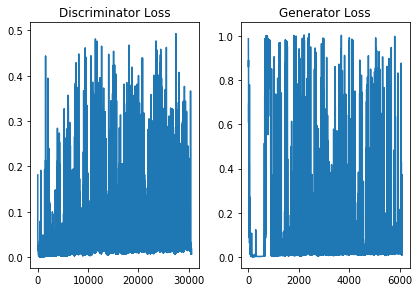

In [12]:
'''Plot discriminator and generator losses'''
figure,axis = plt.subplots(1,2)
plt.tight_layout()
axis[0].plot(discriminator_loss)
axis[0].set_title("Discriminator Loss")
axis[1].plot(generator_loss)
axis[1].set_title("Generator Loss")

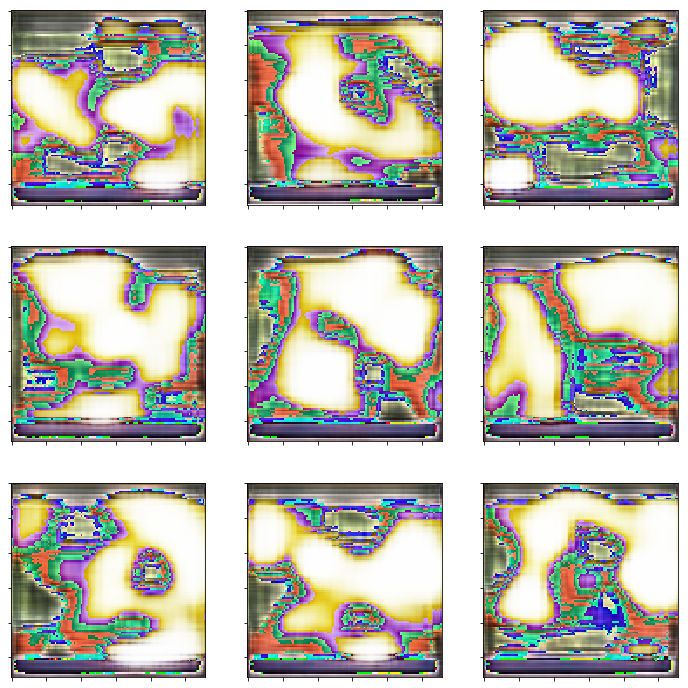

In [13]:
'''Generate images with our trained generator model'''
num_generated = 9
in_noise = np.random.rand(num_generated,100)
im = generator_model.predict(in_noise)
figure,axis = plt.subplots(3,3,figsize=(10,10))
plt.tight_layout()
for i in range(3):
    for j in range(3):
        axis[i,j].imshow(im[i*3+j])
        axis[i,j].set_yticklabels([])
        axis[i,j].set_xticklabels([])

In [ ]:
'''Save weights and models'''
discriminator_model.save_weights('discriminator_deepmodel_weights.h5')
generator_model.save_weights('generator_deepmodel_weights.h5')
model.save_weights('gan_deepmodel_weights.h5')

discriminator_model.save('discriminator_deepmodel.h5')
generator_model.save('generator_deepmodel.h5')
model.save('gan_deepmodel.h5')